In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pickle
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Importing libraries
from skimage.io import imshow, imread, imsave
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.filters import threshold_otsu, gaussian, sobel, gabor
from skimage.morphology import closing, disk
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import resize
from skimage import morphology
import skimage
import imageio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from skimage.filters.rank import entropy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew
import cv2
import requests as rq
import os, sys, time, PIL
import ipywidgets as widgets
from IPython.display import HTML, clear_output
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
train_images = []
train_labels = []

parent_path = '/gdrive/MyDrive/Data'
label = 0
for child in os.listdir(parent_path):
  child_path = f"{parent_path}/{child}"
  # child_path_bgremoved = f"/content/train_bgremoved/{child}_bgremoved"
  # os.mkdir(child_path_bgremoved)
  print(f"Label {label} -> {child}")
  for img in os.listdir(child_path):
    train_images.append(f'{child_path}/{img}')
    train_labels.append(label)
  label = label + 1

Label 0 -> Hispa
Label 1 -> LeafBlast
Label 2 -> Healthy
Label 3 -> BrownSpot


In [ ]:
train_labels

In [ ]:
x_train, y_train= train_images, train_labels


In [ ]:
x_train

In [ ]:
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    count=1
    for image in dataset:  #iterate through each file 
        print(str(count)+" Read succesfully")
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = cv2.imread(image) #Reading image from path
        #Add more filters as needed
        # entropy = shannon_entropy(img)
        # df['Entropy'] = [entropy]
        #CALCULATING R,G,B MEAN
        RGB_MEAN = cv2.mean(img)
        df["Red"]=[RGB_MEAN[0]]
        df["Green"]=[RGB_MEAN[1]]
        df["Blue"]=[RGB_MEAN[2]]

        # CALCULATING H,S,V MEAN BY CONVERTING INTO HSV IMAGE
        hsvImage = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        HSV_MEAN = cv2.mean(hsvImage)
        df["H_Value"]=[HSV_MEAN[0]]
        df["S_Value"]=[HSV_MEAN[1]]
        df["V_Value"]=[HSV_MEAN[2]]

        # CALCULATING L,A,B MEAN VALUES BY CONVERTING INTO LAB IMAGE
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        LAB_MEAN=cv2.mean(lab_image)
        df["L_VALUE"]=[LAB_MEAN[0]]
        df["A_VALUE"]=[LAB_MEAN[1]]
        df["B_VALUE"]=[LAB_MEAN[2]]
        


        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # df["skewness"]=skew(gray_img.reshape(-1))
        # df["kurtosis"]=kurtosis(gray_img.reshape(-1))

        thetas= [0, np.pi/4, np.pi/2, 3*np.pi/4]
        num=1
        for theta in thetas:      
          GLCM = greycomatrix(gray_img, [1], [theta])       
          GLCM_Energy = greycoprops(GLCM, 'energy')[0]
          df['Energy '+str(num)] = GLCM_Energy
          GLCM_corr = greycoprops(GLCM, 'correlation')[0]
          df['Corr '+str(num)] = GLCM_corr     
          # GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
          # df['Diss_sim '+str(num)] = [GLCM_diss]       
          GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
          df['Homogen '+str(num)] = GLCM_hom      
          GLCM_contr = greycoprops(GLCM, 'contrast')[0]
          df['Contrast '+str(num)] = GLCM_contr
          num=num+1
        


        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        count=count+1
    return image_dataset

In [ ]:
image_features = feature_extractor(x_train)

In [ ]:
image_features

,Red,Green,Blue,H_Value,S_Value,V_Value,L_VALUE,A_VALUE,B_VALUE,Energy 1,...,Homogen 2,Contrast 2,Energy 3,Corr 3,Homogen 3,Contrast 3,Energy 4,Corr 4,Homogen 4,Contrast 4
0,0.283738,1.650745,1.460017,0.653022,4.113560,1.654998,1.675715,127.734641,128.697939,0.975655,...,0.982719,79.177559,0.977883,0.807471,0.990647,45.613371,0.975830,0.691796,0.984409,73.131002
0,0.401868,0.784714,0.745137,0.187202,0.722969,0.784714,0.798706,127.927383,128.197944,0.992345,...,0.993544,71.991742,0.991338,0.466971,0.992200,112.186708,0.990568,0.283248,0.991176,150.874493
0,0.156040,0.520957,0.470723,0.245979,1.321582,0.522441,0.534163,127.921228,128.203643,0.989787,...,0.994830,20.128570,0.989714,0.591577,0.993078,25.447721,0.988714,0.447970,0.991091,34.210261
0,0.414524,0.578694,0.690337,0.122339,0.773440,0.690337,0.644451,128.022092,128.114863,0.991409,...,0.993474,23.367201,0.992598,0.930814,0.997162,7.485047,0.991065,0.654223,0.991654,37.467123
0,0.338540,0.541472,0.558726,0.165193,0.635083,0.558726,0.578501,127.969766,128.120918,0.992166,...,0.995715,22.704803,0.991462,0.570254,0.993060,39.589828,0.990576,0.416044,0.991307,53.787579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.581096,3.678984,4.211980,0.654041,4.609009,4.211980,3.924421,127.952214,129.160601,0.966442,...,0.981569,113.932722,0.966730,0.828846,0.976726,169.798592,0.964110,0.710401,0.970297,287.442142
0,1.348091,6.478284,6.707478,1.635745,11.604673,6.707478,6.795391,127.463538,130.646985,0.930141,...,0.963751,280.205870,0.931635,0.774049,0.966034,269.296770,0.929103,0.731662,0.957768,320.285111
0,0.955581,10.512522,7.667585,3.117158,18.616677,10.512522,10.302827,125.714702,132.122271,0.914421,...,0.957186,127.723441,0.916613,0.955275,0.974141,76.499934,0.913689,0.918160,0.953766,140.182481
0,2.736323,15.006816,14.494287,3.690967,24.941956,15.058962,15.443147,126.315156,133.981604,0.865844,...,0.929553,341.960658,0.868213,0.888884,0.938132,300.676937,0.863598,0.846581,0.917916,415.710385


In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators= 50, min_samples_split= 10, max_depth= 80, bootstrap= True)
{'n_estimators': 50, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 50}

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(image_features,train_labels,test_size=0.2)

In [ ]:
RF_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50)

In [ ]:
test_prediction = RF_model.predict(X_test)

In [ ]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(Y_test, test_prediction))

Accuracy =  0.7307692307692307


In [ ]:
print(classification_report(Y_test, test_prediction,digits=4)) 

              precision    recall  f1-score   support

           0     0.5895    0.7273    0.6512        77
           1     0.6528    0.5402    0.5912        87
           2     0.9481    0.9865    0.9669        74
           3     0.7647    0.7027    0.7324        74

    accuracy                         0.7308       312
   macro avg     0.7388    0.7392    0.7354       312
weighted avg     0.7337    0.7308    0.7286       312



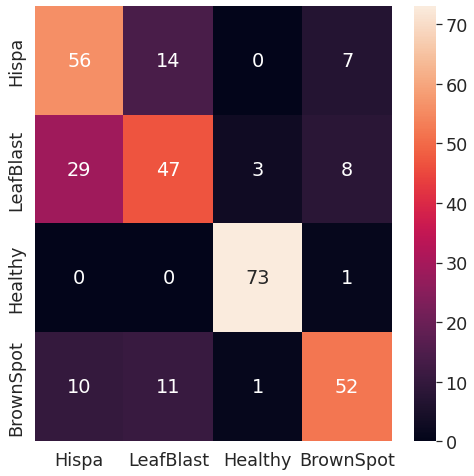

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, test_prediction)

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)
ax.xaxis.set_ticklabels(['Hispa', 'LeafBlast', 'Healthy', 'BrownSpot']); ax.yaxis.set_ticklabels(['Hispa', 'LeafBlast', 'Healthy', 'BrownSpot']);



In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
# iris=load_iris()
X=image_features
Y=train_labels
# logreg=LogisticRegression()
kf=KFold(n_splits=10)
score=cross_val_score(RF_model,X,Y,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.39102564 0.48717949 0.59615385 0.27564103 0.30769231 0.94230769
 0.98717949 0.77419355 0.56774194 0.55483871]
Average Cross Validation score :0.5883953680727874


In [ ]:
#Extracting hue value from image
def hue_extraction(selection):
  img_hsv = rgb2hsv(selection) 
  hue_img = img_hsv[:, :, 0]
  return hue_img

In [ ]:
def remove_background(image_rgb):
    #Creaitng subplots
    # fig = plt.figure(figsize=(10, 7))
    # rows = 2
    # columns = 2

    # convert the image to grayscale
    image_gray = rgb2gray(image_rgb)
    # fig.add_subplot(rows,columns,1)

    # blur the image to denoise
    blurred_image = gaussian(image_gray, sigma=10)
    # fig.add_subplot(rows,columns,2)

    #Creating mask 
    binary = blurred_image < threshold_otsu(blurred_image)
    binary = closing(binary)
    # fig.add_subplot(rows,columns,3)

    selection = np.zeros_like(image_rgb) #background removed image
    selection[binary] = image_rgb[binary]
    # fig.add_subplot(rows,columns,4)
    return selection;

In [ ]:
 def disease_spot_finder(selection,label):
    image1 = np.zeros_like(selection)
    mask1 = (label==0)
    image1[mask1]=selection[mask1]

    image2 = np.zeros_like(selection)
    mask2 = (label==1)
    image2[mask2]=selection[mask2]

    image3 = np.zeros_like(selection)
    mask3 = (label==2)
    image3[mask3]=selection[mask3]
    # plt.imshow(image1)

    g_mean1  =  np.mean(image1, axis=(0, 1))[1]
    g_mean2  =  np.mean(image2, axis=(0, 1))[1]
    g_mean3  =  np.mean(image3, axis=(0, 1))[1]

    # print(f"[{g_mean1}, {g_mean2}, {g_mean3}]")
    arr = [(image1, g_mean1), (image2, g_mean2), (image3, g_mean3)]
    arr.sort(key=lambda x: x[1])
    # output=data.index(srt[1])
    return arr

In [ ]:
def makedir(pt):
  if not os.path.isdir(pt):
    os.mkdir(pt)

Text(0.5, 1.0, 'Image 1')

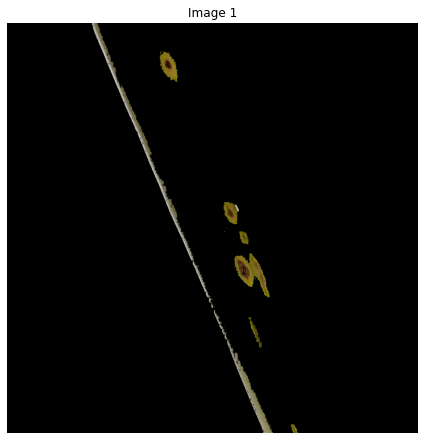

In [ ]:
img_in = "/content/bg_and_otsu/IMG_20190420_195218.jpg"
img_out = "/content/output"
img_name = Path(img_in).name

# leaf_class = "brownspot" #@param ["hispa", "leafblast", "brownspot", "healthy"]

bg_removed_image = remove_background(imread(img_in))


# image_rgb_np = np.array(imread(img_path))
# bg_removed_image = image_rgb_np
# bg_removed_image = image_rgb_np[0:,0:,:-1]
# transparent_ch = image_rgb_np[0:,0:,3]
# image_rgb_np = image_rgb_np[0:,0:,:-1]
# bg_removed_image = np.zeros_like(image_rgb_np)
# transparent_ch_mask = transparent_ch > 0
# bg_removed_image[transparent_ch_mask] = image_rgb_np[transparent_ch_mask]
hue_extracted_image = hue_extraction(bg_removed_image)
image = hue_extracted_image.reshape(-1,1)
image = np.float32(image)
kmeans = KMeans(n_clusters=3,init='k-means++',algorithm='full',n_init=20).fit(image)
label = kmeans.labels_
label = label.reshape(hue_extracted_image.shape)
img_with_disease = disease_spot_finder(bg_removed_image,label)
img1 = img_with_disease[1][0]
img2 = img_with_disease[2][0]
# print(img_with_disease)
# res = mask_green_region(res, hsv_range[0], hsv_range[1])

fig = plt.figure(figsize=(25, 18))
fig.add_subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("Image 1")
# fig.add_subplot(1, 3, 2)
# plt.imshow(img2)
# plt.axis('off')
# plt.title("Image 2")

# imageio.imwrite(f"{img_out}/{leaf_class}/{img_name}", img1)


1 Read succesfully
The prediction for this image is:  Healthy


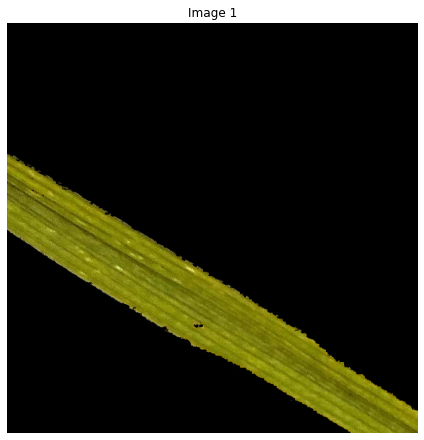

In [ ]:
#Predict

dis = ['Hispa', 'LeafBlast', 'Healthy', 'BrownSpot']
# test_image=cv2.imread('/gdrive/MyDrive/College stuffs/IMG_20190420_194316.png')
input_img_path = "/content/leaf_classes/Healthy.png"
img = imread(input_img_path)

fig = plt.figure(figsize=(25, 18))
fig.add_subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Image 1")

input_img_features=feature_extractor([input_img_path])
img_prediction = pickled_model.predict(input_img_features)
print("The prediction for this image is: ", dis[int(img_prediction)])

In [ ]:
!cp "/gdrive/MyDrive/IMG_20190420_195218.jpg" /content/bg_and_otsu/

In [ ]:
pickle.dump(RF_model, open('/gdrive/MyDrive/Embedded System (1)/model.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('/content/rf_model/model.pkl', 'rb'))

In [ ]:
from sklearn import metrics
test_prediction_latest = pickled_model.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(Y_train, X_train))

In [ ]:
print(f'Final Training Accuracy: {RF_model.score(X_train,Y_train)*100}%')
print(f'Model Accuracy: {RF_model.score(X_test,Y_test)*100}%')

Final Training Accuracy: 93.49397590361446%
Model Accuracy: 73.07692307692307%


In [ ]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [10, 50, 100,200]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)
rf_random.best_params_
rf_random.best_score_
rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       n_estimators=50)